In [1]:
import torch
from torch import nn, Tensor, from_numpy
import torch.nn.functional as F
import torch.optim as optim

from utils import get_data_generator, get_data_tensor, replace_activations
from config import load_config
import numpy as np
import matplotlib.pyplot as plt
from diffusion import get_ddpm

import wandb
from tqdm import trange
from denoising_diffusion_pytorch import Unet

from utils import LeNet, compute_fid, extract_features_statistics
from torch.utils.data import DataLoader
from gan import GANGenerator, add_noise

/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config()
train_data = get_data_tensor(config)
test_data = get_data_tensor(config, train=False)

In [3]:
lenet = LeNet(1024, 10).cuda()
lenet.load_state_dict(torch.load("checkpoints/lenet_mnist.pth"))

mu, sigma = extract_features_statistics(train_data.cuda(), lenet)

diffusion_samples = np.load(config.samples_path)
states = from_numpy(diffusion_samples["states"])
diff_imgs = states[:, 0]
x = torch.clip(from_numpy(diffusion_samples["x"]), 0, 1)

noisy_test_data_loader = DataLoader(add_noise(test_data, 1e-2), batch_size=1000)

mu_diff, sigma_diff = extract_features_statistics(x.cuda(), lenet)
compute_fid(mu, sigma, mu_diff, sigma_diff + 1e-7)

(1.1622903, 2.7165423137968823, 3.8788326484984204)

In [4]:
diffusion_samples["temp"].reshape(-1)

array([9.6084028e-03, 9.6987748e-01, 1.9259267e+00, 2.9672134e+00,
       4.2528205e+00, 6.0487618e+00, 8.9206371e+00, 1.4547878e+01,
       3.1149567e+01, 2.7078770e+03], dtype=float32)

In [4]:
generator = GANGenerator(config)
generator.load_state_dict(torch.load("checkpoints/generator.pth"))
generator = generator.cuda()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


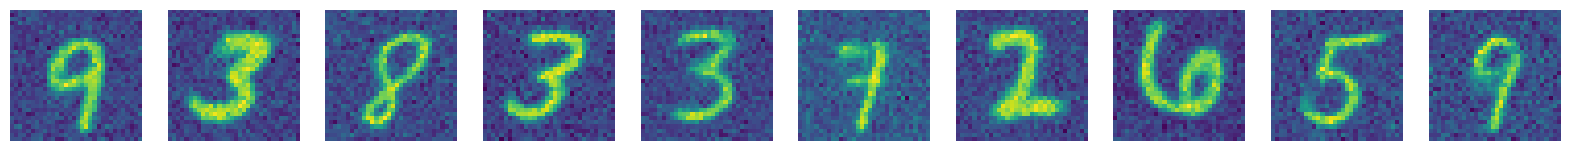

In [5]:
plt.figure(figsize=(20, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(diff_imgs[i, 0])
    plt.axis("off")

In [7]:
device = "cuda"

In [8]:
fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in noisy_test_data_loader], dim=0)
mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-5)[2]

/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


1.3840150819270245

In [11]:
temp = 1e-2

/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


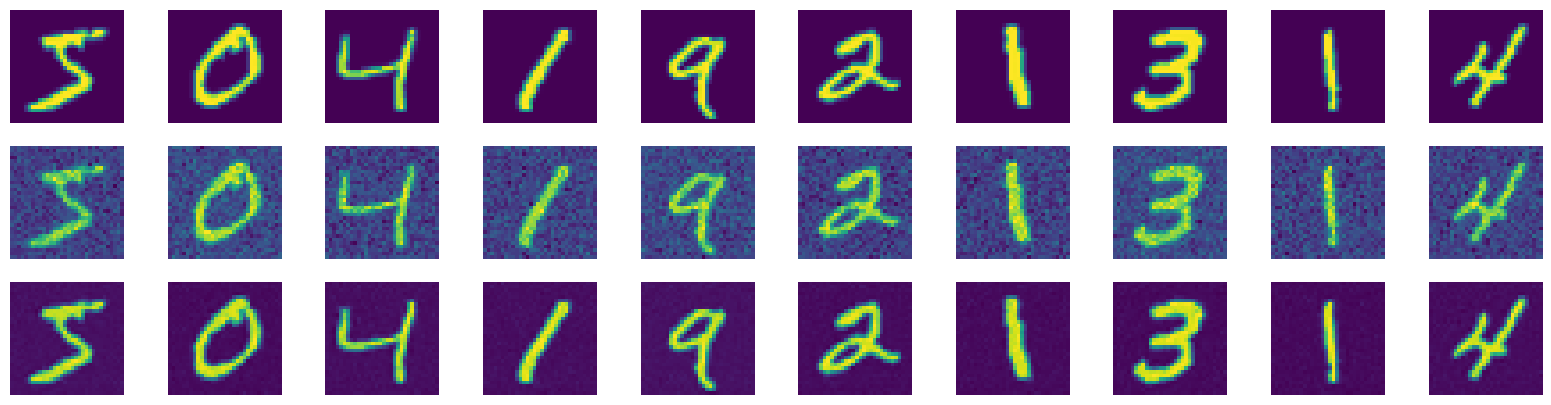

In [12]:
real_imgs = train_data[:20]
noisy_imgs = add_noise(real_imgs, temp)
fake_imgs = generator(noisy_imgs.to(device)).detach().cpu()


plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(real_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(noisy_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")

In [19]:
diff_imgs = states[:, 0]

/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


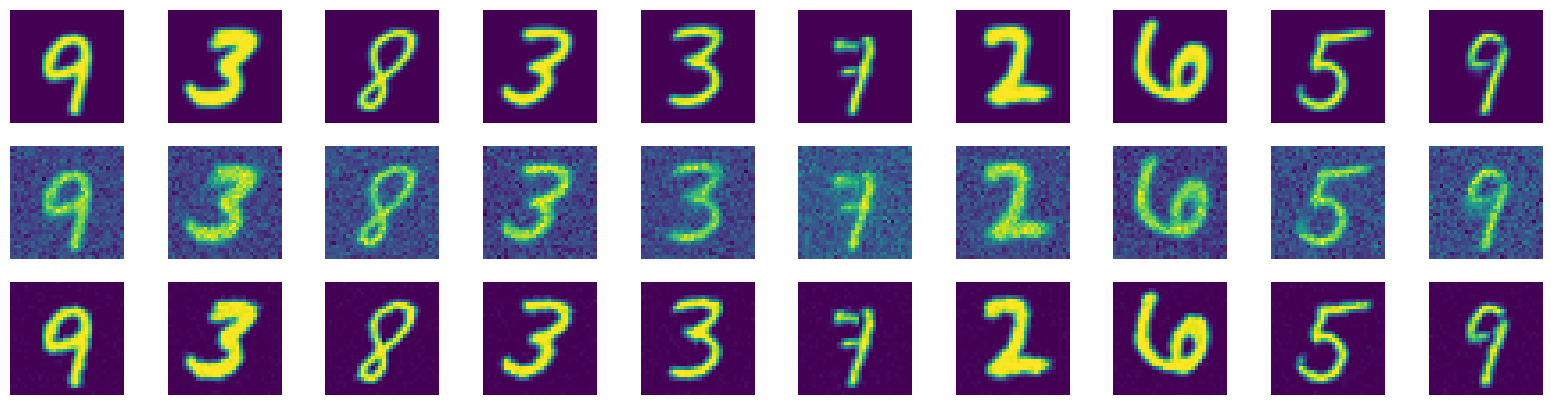

In [20]:
from torch.utils.data import DataLoader


fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in DataLoader(diff_imgs, batch_size=500)], dim=0)


plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(diff_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")

In [28]:
for schedule in ["linear_beta", "cosine"]:
    x_ = from_numpy(np.load(f"results/mnist_50000_iter_{schedule}_schedule_20_steps_samples.npz")["x"])
    mu_eval, sigma_eval = extract_features_statistics(x_.cuda(), lenet)
    print(compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-7)[2])

2.7131706807901894
1.553551139111284


In [14]:
mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-7)

(1.0466502, 2.699502543637125, 3.746152714917032)

In [15]:
mu_x, sigma_x = extract_features_statistics(x.cuda(), lenet)
compute_fid(mu, sigma, mu_x, sigma_x + 1e-7)

(1.1622903, 2.7165423137968823, 3.8788326484984204)

In [16]:
mu_x, sigma_x = extract_features_statistics(torch.clip(x, 0, 1).cuda(), lenet)
compute_fid(mu, sigma, mu_x, sigma_x + 1e-7)

(1.1622903, 2.7165423137968823, 3.8788326484984204)

In [ ]:
diffusion_samples